In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Show the general pipeline used for the GNN models used for cell typing
in the neuron and limb based models referenced in the NEURD paper. This 
tutorial shows how to use the models for inference runs. 
"""

'\nShow the general pipeline used for the GNN models used for cell typing\nin the neuron and limb based models referenced in the NEURD paper. This \ntutorial shows how to use the models for inference runs. \n'

# Installing Dependencies

In [3]:
# !pip3 install torch-scatter -f https://data.pyg.org/whl/torch-1.10.2+cpu.html
# !pip3 install torch-sparse -f https://data.pyg.org/whl/torch-1.10.2+cpu.html
# !pip3 install torch-geometric

# Model Training Background Information

In [4]:
"""
Standard training 
of GNN models using pytorch geometric was used with the following hyper parameters

Neuron Model
------------
1) lr = 0.0001
2) label_weights = {
     '23P': 0.8,
     '4P': 0.5,
     '5P-IT': 1,
     '5P-NP': 1,
     '5P-PT': 1,
     '6P-CT': 0.8,
     '6P-IT': 1,
     'BC': 1,
     'BPC': 1,
     'MC': 1,
     'NGC': 1
    }
3) Dropout (0.5)
4) torch.optim.Adam optimizer
5) batch_size = 64
6) 60/20/20 train/validation/test split

Limb Model
----------
1) lr = 0.001 ** only learning hyper parameter that is different **
2) label_weights = {
     '23P': 0.8,
     '4P': 0.5,
     '5P-IT': 1,
     '5P-NP': 1,
     '5P-PT': 1,
     '6P-CT': 0.8,
     '6P-IT': 1,
     'BC': 1,
     'BPC': 1,
     'MC': 1,
     'NGC': 1
    }
3) Dropout (0.5)
4) torch.optim.Adam optimizer
5) batch_size = 64
6) 60/20/20 train/validation/test split

Note: training 
"""
""

''

# Step 0: Accessing ground truth data

In [5]:
"""
Can get ground truth cell typing labels from the caveclient
"""

'\nCan get ground truth cell typing labels from the caveclient\n'

In [6]:
from vdi_chen import volume_data_interface as vdi

# Step 0: Loading precomputed mesh

In [16]:
from neurd import neuron_utils as nru
from neurd import neuron_visualizations as nviz
from neuron_morphology_tools import neuron_nx_utils as nxu
from mesh_tools import trimesh_utils as tu
from pathlib import Path

In [11]:
data_directory = "./Data_Processed/"
segment_id = 75086130432907868

mesh = tu.load_mesh_no_processing_h5(
    Path(data_directory) / Path(f"{segment_id}_decimated")
)

In [15]:
neuron_obj_path = Path(data_directory) / Path(f"{segment_id}_cell_type.pbz2")
neuron_obj_exc = nru.decompress_neuron(
    neuron_obj_path,
    original_mesh=mesh,
)


Decompressing Neuron in minimal output mode...please wait


In [19]:
nviz.visualize_neuron(neuron_obj_exc,limb_branch_dict="all"from . import neuron_graph_lite_utils as ctcu)


 Working on visualization type: mesh

 Working on visualization type: skeleton


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [21]:
from neurd import neuron_graph_lite_utils as glite
G_exc = glite.G_with_attrs_from_neuron_obj(
        neuron_obj_exc,
        plot_G=False,
)

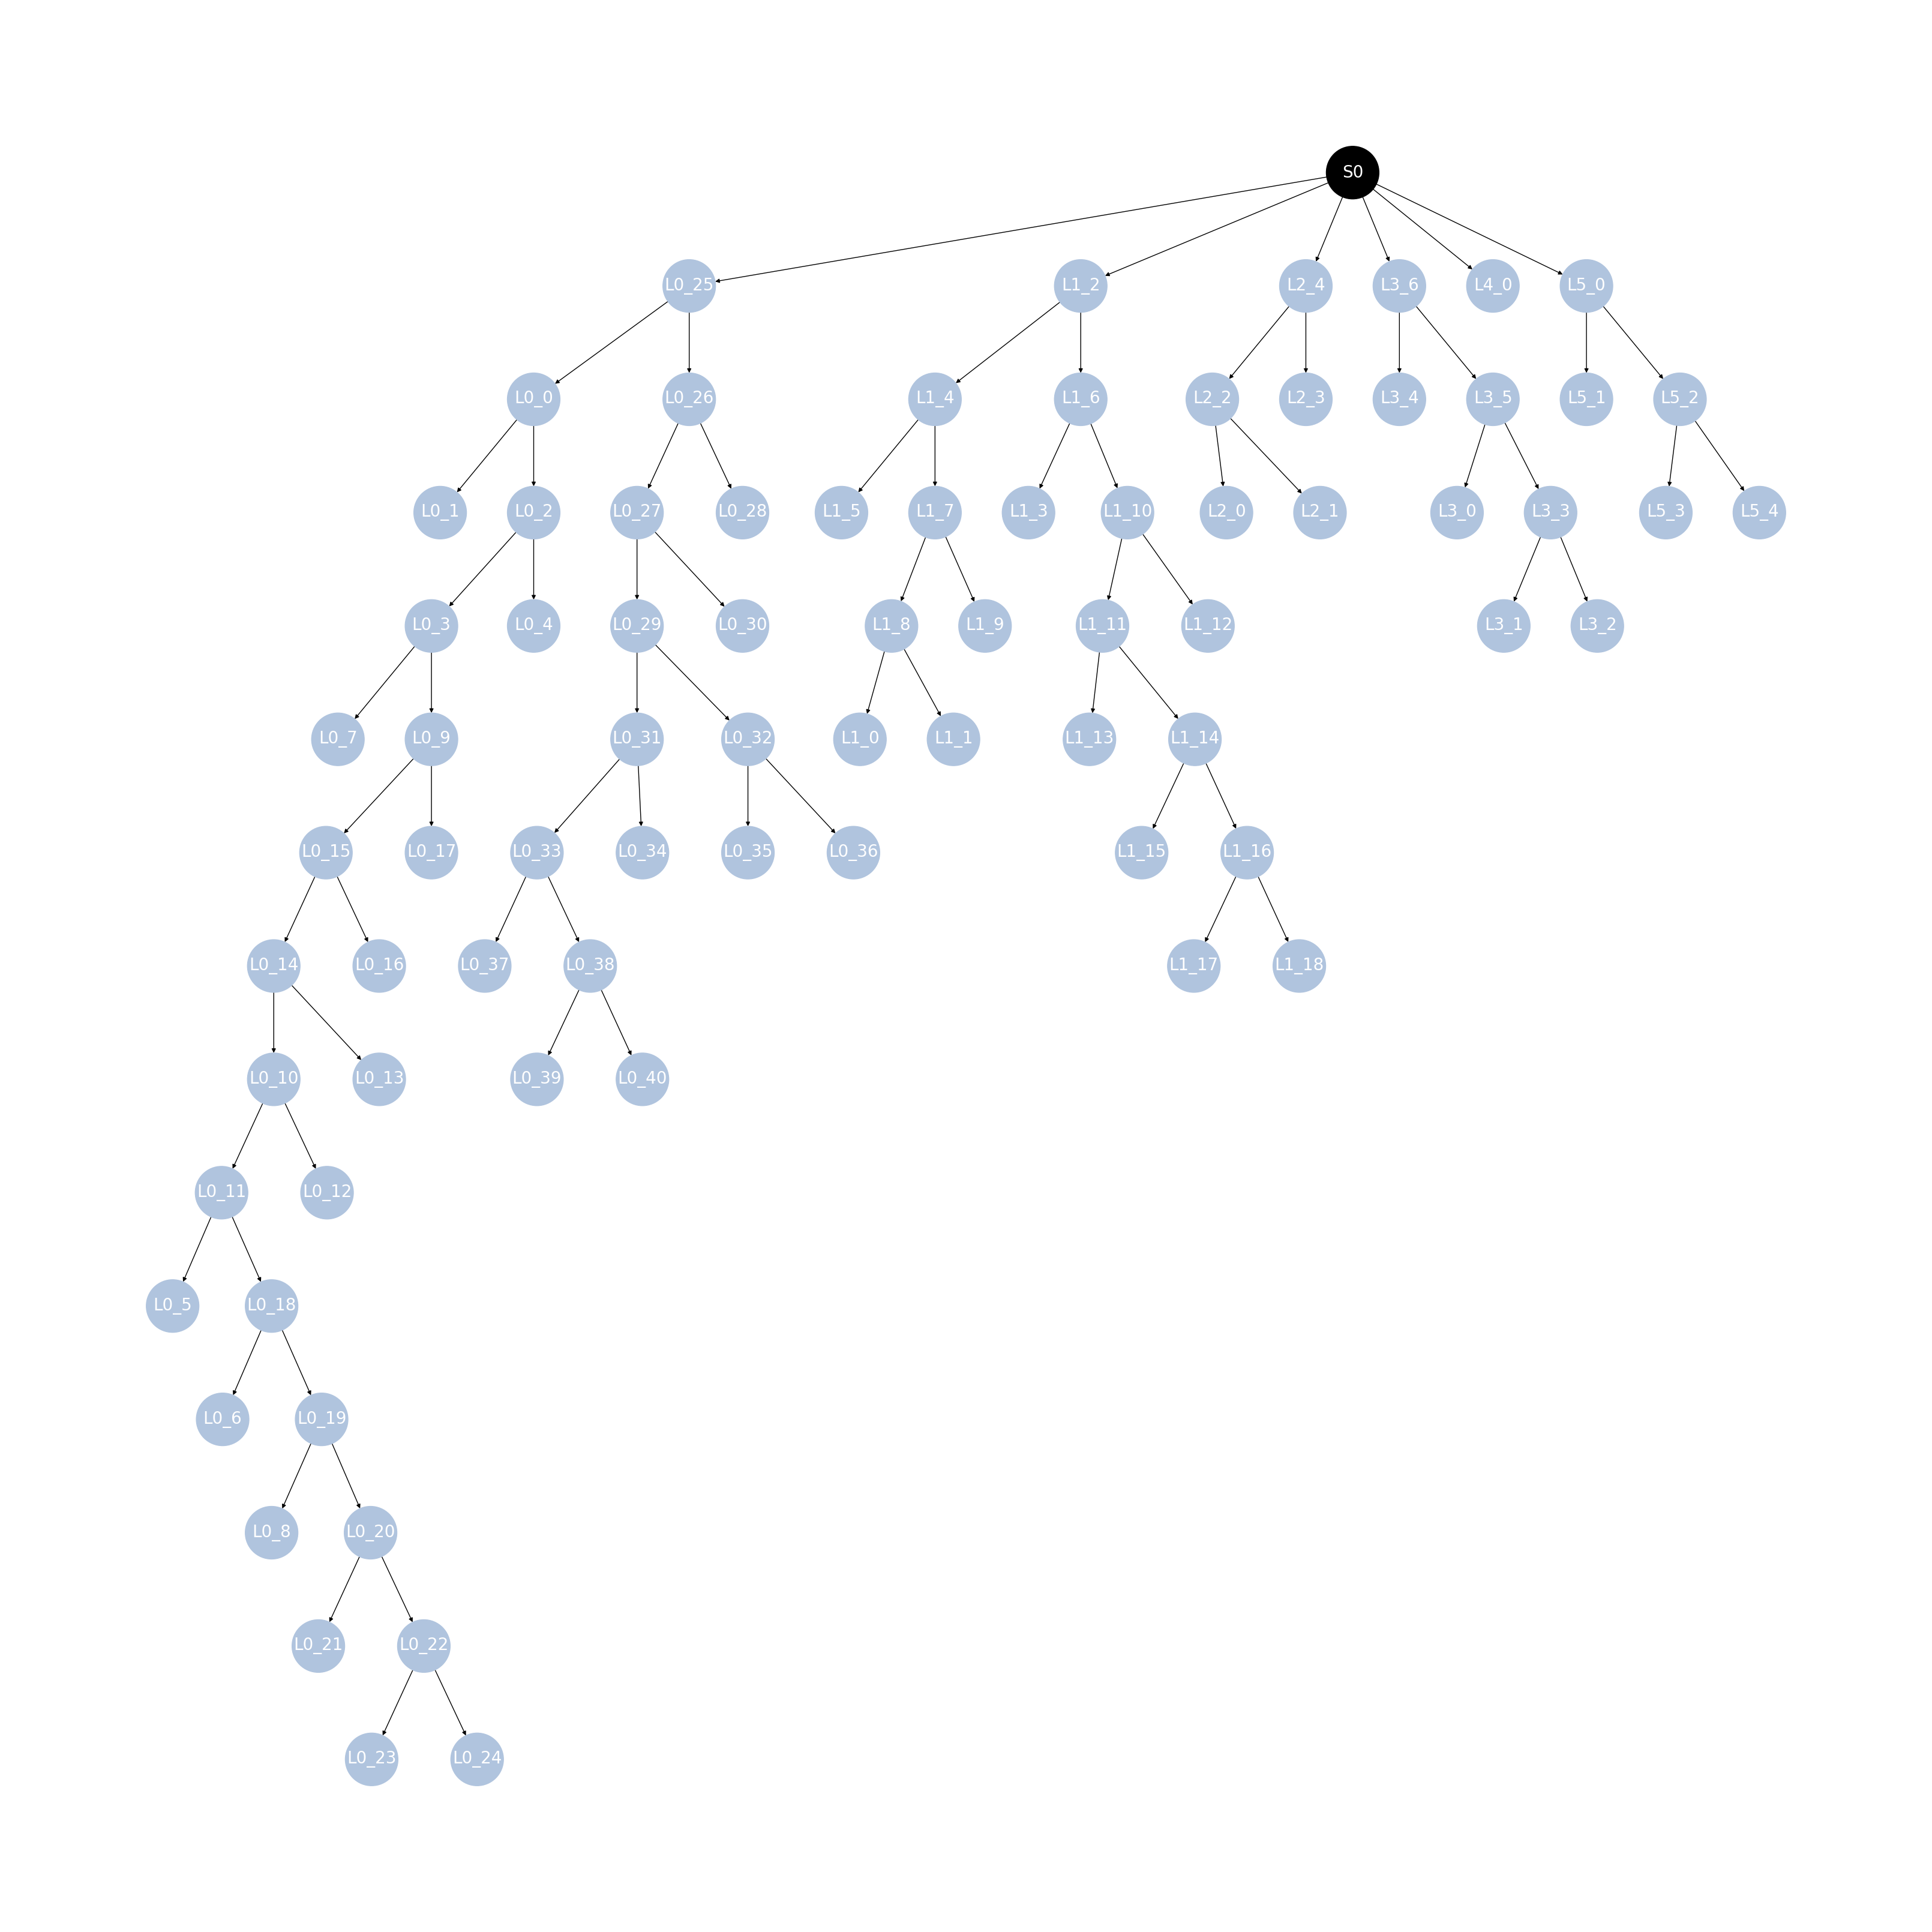

In [22]:
nxu.draw_tree(G_exc)

# Step 1: Transforming networkx graphs into dataset objects (that can be easily converted to pytorch geometric dataset objects)

In [23]:
from neurd.gnn_cell_typing_utils import NeuronGraphData,OutputClassConfig
from neurd import gnn_cell_typing_utils as gnnu

In [25]:
exc_cell_type = "23P" # replace with your own cell type
Gs = [
    (G_exc,exc_cell_type),
]

In [27]:
# restricting to features without synapses
from neuron_morphology_tools import neuron_nx_feature_processing as nxf
features_no_syn = [k for k in nxf.features_to_output_for_gnn if "syn" not in k]
features_no_syn

['skeletal_length',
 'skeleton_vector_upstream_theta',
 'skeleton_vector_upstream_phi',
 'skeleton_vector_downstream_theta',
 'skeleton_vector_downstream_phi',
 'width_upstream',
 'width_no_spine',
 'width_downstream',
 'n_spines',
 'spine_volume_sum']

In [30]:
# converting networkx graphs into dataset objects
G_data = [NeuronGraphData(k,label=v,features = features_no_syn) for k,v in Gs]
Gd = G_data[0]
Gd

Neuron 75086130432907868_0 (Nodes = 78, Edges = 144, Features = 13)

In [31]:
# deciding whether to use full neurons or limbs of neurons as graph data

# full neurons as instances
graph_data_list_neuron = G_data

#neuron limbs as instances
graph_data_list_limbs = [limb_G for neurons in G_data for limb_G in neurons.limb_data_objs]

In [34]:
Gd.feature_df

,skeletal_length,skeleton_vector_upstream_theta,skeleton_vector_upstream_phi,skeleton_vector_downstream_theta,skeleton_vector_downstream_phi,width_upstream,width_no_spine,width_downstream,n_spines,spine_volume_sum,soma_start_angle_max,max_soma_volume,n_syn_soma
0,2207.450643,0.992988,2.189188,0.935297,2.199665,1146.519628,1146.519628,1146.519628,0,0.0,143.57,1055.95025,1477
1,2960.234494,1.011013,0.535827,0.440109,0.520111,379.152943,400.180678,379.152943,0,0.0,143.57,1055.95025,1477
2,27435.845949,1.365976,2.612883,1.413350,2.709198,640.325522,823.095481,906.191757,0,0.0,143.57,1055.95025,1477
3,2581.387829,2.497033,3.073089,2.896895,3.028997,411.750320,405.867997,411.750320,0,0.0,143.57,1055.95025,1477
4,10899.340821,0.668162,0.705885,0.289768,0.812967,340.364754,351.710113,380.010625,0,0.0,143.57,1055.95025,1477
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,13388.330882,0.988972,0.133962,1.539533,0.081803,279.668762,255.337760,159.091083,0,0.0,52.33,1055.95025,1477
74,9356.002625,0.212125,-2.661719,0.060655,-1.856218,260.581298,269.278482,316.319977,0,0.0,52.33,1055.95025,1477
75,25039.962803,1.558660,-0.627359,1.484689,-0.262452,421.570146,344.929803,276.306965,0,0.0,52.33,1055.95025,1477
76,6656.825419,1.245567,-0.739867,1.316482,-0.617461,419.321847,437.997785,449.718606,0,0.0,52.33,1055.95025,1477


In [35]:
Gd.edge_index

array([[ 0,  1],
       [ 0,  2],
       [ 1,  0],
       [ 1,  3],
       [ 1,  4],
       [ 2,  0],
       [ 2,  5],
       [ 2,  6],
       [ 3,  1],
       [ 4,  1],
       [ 4,  7],
       [ 4,  8],
       [ 5,  2],
       [ 5,  9],
       [ 5, 10],
       [ 6,  2],
       [ 7,  4],
       [ 7, 11],
       [ 7, 12],
       [ 8,  4],
       [ 9,  5],
       [ 9, 13],
       [ 9, 14],
       [10,  5],
       [11,  7],
       [12,  7],
       [12, 15],
       [12, 16],
       [13,  9],
       [13, 17],
       [13, 18],
       [14,  9],
       [14, 19],
       [14, 20],
       [15, 12],
       [15, 21],
       [15, 22],
       [16, 12],
       [17, 13],
       [17, 23],
       [17, 24],
       [18, 13],
       [19, 14],
       [20, 14],
       [21, 15],
       [21, 25],
       [21, 26],
       [22, 15],
       [23, 17],
       [24, 17],
       [24, 27],
       [24, 28],
       [25, 21],
       [25, 29],
       [25, 30],
       [26, 21],
       [27, 24],
       [28, 24],
       [29, 25

# Now that graph data is created, can now train GNN (using correct ground truth labels, feature normilzation). The rest of the code is just partial pseudocode and will need to implement it more thoroughly for your dataset

## a) Loading the normalization mean/std

In [ ]:
from datasci_tools import pandas_utils as pu
df_norm_filepath = [NEED TO PROVIDE]
df_norm = pu.csv_to_df(df_norm_filepath)
df_norm

## b) Creating the class mapping

In [ ]:
cell_type_mapping = [NEED TO PROVIDE] # EX: Gnnu.microns_cell_type_map
class_config = OutputClassConfig()
class_config

## c) Creating Pytorch Datasets

In [ ]:
from neurd.gnn_cell_typing_utils import NeuronDataset

torch_data_obj_neuron = NeuronDataset(
    graph_data_list_neuron,
    normalization_df=df_norm,
    class_config = class_config,
)
# the pytorch geometric dataset 
torch_data_obj_neuron.dataset

In [ ]:
torch_data_obj_limb = NeuronDataset(
    graph_data_list_limbs,
    normalization_df=df_norm,
    class_config = class_config,
)

# the pytorch geometric dataset 
torch_data_obj_limb.dataset

## d) Creating a dataloader

# Step 3: Loading the Model and running inference

In [ ]:
batch_size = 20

## Option 1: Neuron Based Model

### a) Instantiating model

In [ ]:
model_architecture_kwargs = architecture_kwargs = dict(
    num_node_features = torch_data_obj_neuron.dataset[0].x.shape[1],
    num_classes = class_config.num_classes,
    activation_function = "relu",
    global_pool_type="mean_weighted",
    global_pool_weight = "node_weight",
    
    n_hidden_channels=128,
    n_layers = 2,
    
    #batch norm specifics
    use_bn = True,
    track_running_stats=True,
)

model = gnnu.NeuronGCN(**architecture_kwargs)
model_weights = "./models/neuron_gnn_2_layer"

neuron_input_obj = gnnu.GnnInput(
    dataset_obj = torch_data_obj_neuron,
    model = model,
    model_weights_filepath = model_weights,
    class_config = class_config,
)

neuron_input_obj.model

### b) Inference Run

In [ ]:
inf_obj = gnnu.InferenceRunner(neuron_input_obj)
inf_obj.run()

In [ ]:
inf_obj.prediction_df